##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<h2>准备数据</h2>

<h3>下载数据</h3>

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip

--2021-02-11 06:27:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.12.240, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   153MB/s    in 0.9s    

2021-02-11 06:27:41 (153 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-02-11 06:27:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.12.240, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148018

<h3>整理数据</h3>

In [2]:
import os
from zipfile import ZipFile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('../data/HorseAndHuman/train_data/')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('../data/HorseAndHuman/validation_data/')
zip_ref.close()

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('../data/HorseAndHuman/train_data/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('../data/HorseAndHuman/train_data/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('../data/HorseAndHuman/validation_data/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('../data/HorseAndHuman/validation_data/humans')

## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

<h3>导包</h3>

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, History, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.backend import clear_session
from tensorflow.compat.v1 import reset_default_graph

<h3>初始化</h3>

In [5]:
clear_session()
reset_default_graph()
# 设置显存自动增长
physical_devices = tf.config.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, enable=True)

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

<h3>搭建模型</h3>

In [6]:
model = Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', name="conv2d_1", input_shape=(300, 300, 3)),
    MaxPool2D(pool_size=(2, 2), name="pool2d_1"),
    # The second convolution
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv2d_2"),
    MaxPool2D(pool_size=(2, 2), name="pool2d_2"),
    # The third convolution
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name="conv2d_3"),
    MaxPool2D(pool_size=(2, 2), name="pool2d_3"),
    # The fourth convolution
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name="conv2d_4"),
    MaxPool2D(pool_size=(2, 2), name="pool2d_4"),
    # The fifth convolution
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name="conv2d_5"),
    MaxPool2D(pool_size=(2, 2), name="pool2d_5"),
    # Flatten the results to feed into a DNN
    Flatten(name="flatten_6"),
    # 512 neuron hidden layer
    Dense(units=512, activation='relu', name="dense_6"),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    Dense(units=1, activation='sigmoid', name="dense_7")
], name="horse_human_classifier")

In [7]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
model.summary()

Model: "horse_human_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
pool2d_1 (MaxPooling2D)      (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
pool2d_2 (MaxPooling2D)      (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
pool2d_3 (MaxPooling2D)      (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 

<h2>数据增强</h2>

In [8]:
# 训练集增强
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 验证集不增强
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    directory='../data/HorseAndHuman/train_data/',  # This is the source directory for training images
    target_size=(300, 300),  # All images will be resized to 300x300
    batch_size=128,
    class_mode='binary' # Since we use binary_crossentropy loss, we need binary labels
)

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    directory='../data/HorseAndHuman/validation_data/',  # This is the source directory for training images
    target_size=(300, 300),  # All images will be resized to 300x300
    batch_size=32,
    class_mode='binary' # Since we use binary_crossentropy loss, we need binary labels
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


<h2>训练模型</h2>

In [9]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=8,  
    validation_steps=8,
    epochs=100,
    workers=-1,
    use_multiprocessing=True
)

Epoch 1/100
8/8 [==============================] - 29s 3s/step - loss: 0.6912 - accuracy: 0.5372 - val_loss: 0.6753 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 21s 3s/step - loss: 0.6810 - accuracy: 0.5316 - val_loss: 0.6515 - val_accuracy: 0.5625
Epoch 3/100
8/8 [==============================] - 22s 3s/step - loss: 0.6628 - accuracy: 0.6703 - val_loss: 0.6509 - val_accuracy: 0.5117
Epoch 4/100
8/8 [==============================] - 24s 3s/step - loss: 0.6392 - accuracy: 0.6542 - val_loss: 0.5486 - val_accuracy: 0.8398
Epoch 5/100
8/8 [==============================] - 21s 3s/step - loss: 0.5999 - accuracy: 0.7042 - val_loss: 0.5468 - val_accuracy: 0.6797
Epoch 6/100
8/8 [==============================] - 21s 3s/step - loss: 0.5966 - accuracy: 0.7002 - val_loss: 0.6129 - val_accuracy: 0.5781
Epoch 7/100
8/8 [==============================] - 21s 3s/step - loss: 0.5378 - accuracy: 0.7403 - val_loss: 0.6457 - val_accuracy: 0.5859
Epoch 8/100
8/8 [==========

<h2>画图</h2>

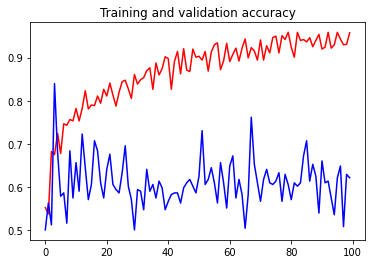

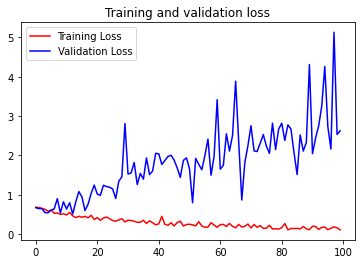

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()